In [7]:
# imports 
import networkx as nx
import numpy as np
from plot_config import *
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import svd

### Different graph types visualization 
Number of **nodes**: n = 64; Number of **qubits**: 6 

**Cycle Graph**: a path with its two end-nodes connected.

**Path Graph**: n linearly connected nodes (a path / 1D line). 

**Star Graph**: one center node connected to n-1 outer node. 

**Binomial Tree**: a recursively defined tree where a binomial tree of order 0 has a single node, and a tree of order k is formed by linking two binomial trees of order k-1. It contains n = $2^k$ nodes. 

**Hyper Cube**: a network of nodes connected by edges that represents a $k$ dimensional version of a cube. It contains n = $2^k$ nodes. 

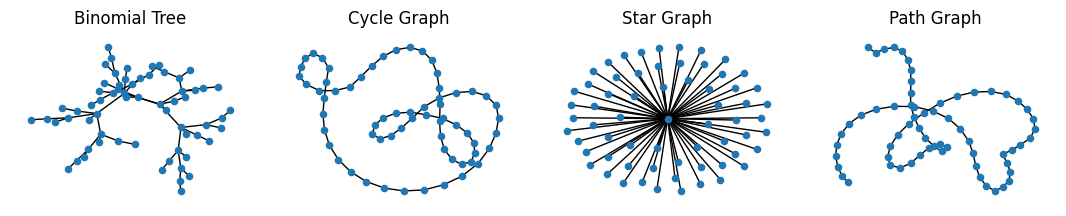

In [42]:
n = 2**6
G1 = nx.cycle_graph(n)
G2 = nx.path_graph(n)
G4 = nx.star_graph(n-1) 
G5 = nx.binomial_tree(6)

fig, axes = plt.subplots(1, 4, figsize=(11, 2.5)) 

nx.draw(G5, node_size=20, ax=axes[0])
axes[0].set_title("Binomial Tree", fontsize=12)

nx.draw(G4, node_size=20, ax=axes[2])
axes[2].set_title("Star Graph", fontsize=12)

nx.draw(G1, node_size=20, ax=axes[1])
axes[1].set_title("Cycle Graph", fontsize=12)

nx.draw(G2, node_size=20, ax=axes[3])
axes[3].set_title("Path Graph", fontsize=12)

plt.show()

### Functions for simulating quantum walks on graphs and analyzing their entanglement dynamics: 
**evolve(H, t, type)**  
Evolves a quantum state $|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$ under the graph Laplacian $L$.  
  - Initial state is localized at node 0.  
  - Returns the probability distribution across nodes and the corresponding entropy.

**vn_entropy(psi, dims)**  
Computes the von Neumann entropy of a bipartitioned system by performing a decomposition via SVD.  
  - Entropy serves as a measure of entanglement or “spread” of the quantum walk.  
  - Here, we split the system into equally two halves. 
  - Formula:  

    $S(\rho) = - \text {Tr} [\rho \log \rho] = - \sum_i \lambda_i \log_2 \lambda_i$
    
    where $\lambda_i$ are the eigenvalues of the reduced density matrix.

**evolve_entropy(L, psi, t, type)**  
Tracks how entropy grows over time as the quantum state evolves.  


In [4]:
def evolve(H, t: float, dims: (int, int)):
    N = H.shape[0]
    psi0 = np.zeros(N, dtype=complex)
    psi0[0] = 1.0
    psi_t = expm_multiply(-1j * H, psi0, start=0.0, stop=t)[-1]
    e = evolve_entropy(H, psi0, t, dims) 
    return np.abs(psi_t)**2, e

def vn_entropy(psi: np.ndarray, dims: (int, int)):
    dA, dB = dims
    psi_matrix = psi.reshape(dA, dB)
    U, D, Vt = svd(psi_matrix, full_matrices=False)
    D = D / np.linalg.norm(D)
    l = D**2
    eps = 1e-12
    l = l[l > eps] 
    S = -np.sum(l * np.log(l) / np.log(2))
    return S

def evolve_entropy(L, psi: np.ndarray, t: float, dims: (int, int)):
    entropy_list = [] 
    t_list = np.linspace(0, t, t) 
    for t in t_list: 
        psi_t = expm_multiply(-1j * L * t, psi)
        S = vn_entropy(psi_t, dims)
        entropy_list.append(S)
        
    return entropy_list 
    

In [18]:
n = 2**6
graphs = {
    "binomial_tree": nx.binomial_tree(6),
    "cycle": nx.cycle_graph(n),
    "star" : nx.star_graph(n-1), 
    "path": nx.path_graph(n),
}
e_list = [] 

for name, G in graphs.items():
    L = nx.laplacian_matrix(G)
    p, e = evolve(L, 100, (8,8))
    e_list.append(e) 


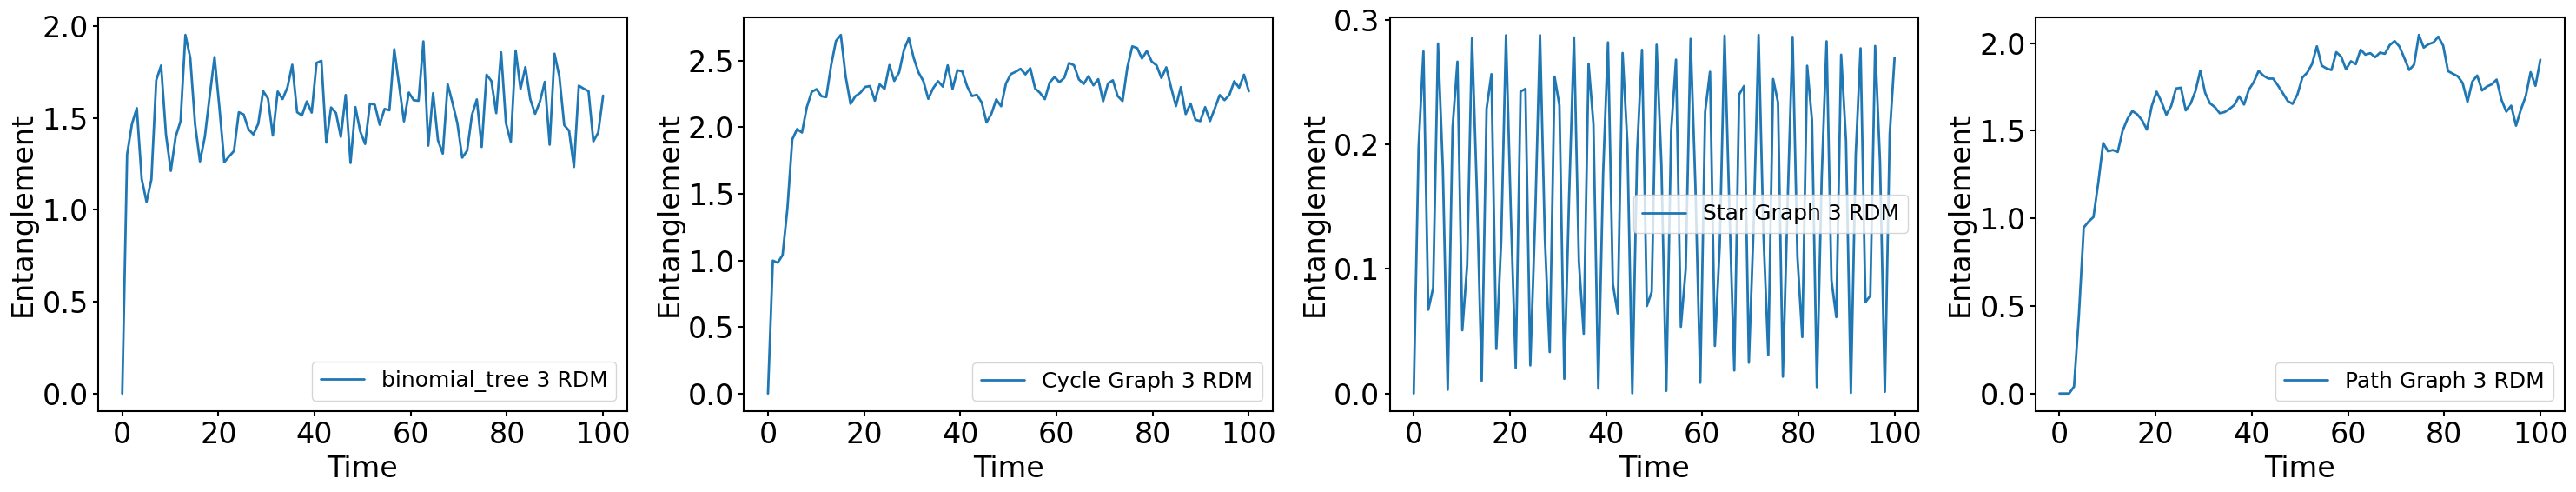

In [19]:
graph_names = ["binomial_tree", "Cycle Graph", "Star Graph", "Path Graph"]
x = np.linspace(0, 100, 100) 
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 6), sharex=True)

for i in range(4):
    axes[i].plot(x, e_list[i], label=f'{graph_names[i]} 3 RDM')
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Entanglement")
    
    axes[i].legend()


### Dynamics of quantum walk on glued tree

In [20]:
from glue_tree import *
from plot_config import *


### Glued-Tree Column Hamiltonian

In a glued tree of depth n, nodes that are the same distance from the entrance are collapsed into a single column. 

This yields a 1D chain of $N = 2n + 1$ columns indexed $0,1,\dots,2n$, where:
- 0 is the entrance column,
- $n$ is the middle (glued) column,
- $2n$ is the exit column.

The following function constructs a weighted Laplacian on this column chain, with elements defined in the paper: 

$\gamma$ is set to 1. 

$\langle \text{col } j \,|\, H \,|\, (\text{col } j \pm 1) \rangle = -\sqrt{2}\,\gamma$

**Off-diagonal elements:** These describe the hopping amplitudes between neighboring columns. The walker can hop from column $j$ to $j+1$ or $j-1$. The factor of $\sqrt{2}$ comes from the two forward edges in the left tree (or backward edges in the right tree), which boost the effective amplitude when collapsing nodes into a single column state.

$
\langle \text{col } j \,|\, H \,|\, \text{col } j \rangle =
\begin{cases}
2\gamma & \quad j = 0,\, n,\, 2n \\
3\gamma & \quad \text{otherwise}
\end{cases}
$

**Diagonal elements**: we set the diagonal (degree) elements to 3 on most columns to roughly match the total edge counts (2 outgoing and 1 backward or vice versa), and reduce it to 2 at the entrance (0), glued/middle (n), and exit (2n) columns to reflect their reduced connectivity.



#### This column Laplacian is then used as the Hamiltonian in the same evolution and entropy routines defined earlier. 
The state is evolved via $\exp(-iHt)$.

In [25]:
def column_laplacian_H(n: int) -> csr_matrix:
    N = 2*n + 1
    off = np.full(N-1, -np.sqrt(2.0), dtype=float)
    # print(off)
    A = diags([off, off], offsets=[-1,1], shape=(N,N), format="csr")
    degrees = np.zeros(N, dtype=float)
    degrees[:] = 3
    degrees[0], degrees[n], degrees[N-1] = 2, 2, 2
    D = diags([degrees], [0], shape=(N,N), format="csr")
    # print(A+D)
    return (A + D).tocsr()

In [26]:
n = 500
dims = (77, 13)
H = column_laplacian_H(n)

p_100, e_100 = evolve(H, 100, dims)
p_250, e_250 = evolve(H, 250, dims)
p_400, e_400 = evolve(H, 400, dims)
p_600, e_600 = evolve(H, 600, dims)


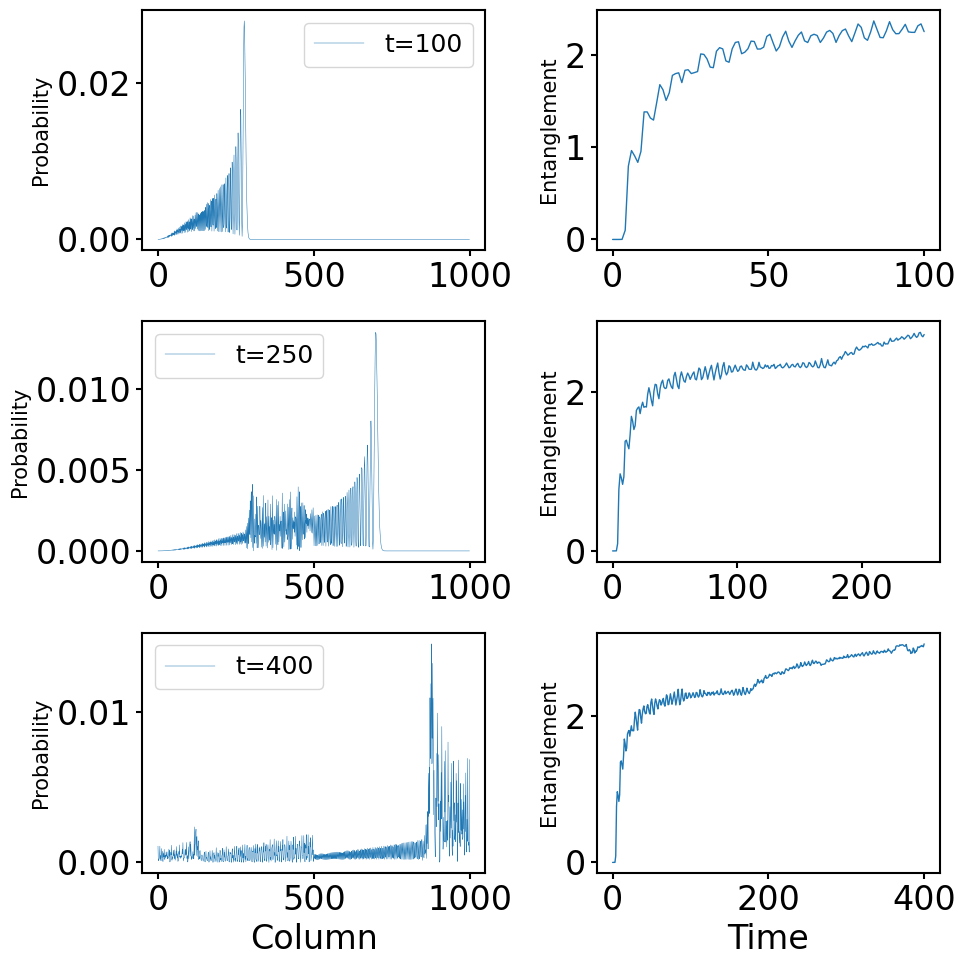

In [28]:
x = np.arange(0, 2*n+1)
t = np.linspace(0, 100, 100)
t1 = np.linspace(0, 250, 250)
t2 = np.linspace(0, 400, 400)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=False)
axes[0, 0].plot(x, p_100, label='t=100', linewidth=0.35)
axes[1, 0].plot(x, p_250, label='t=250', linewidth=0.35)
axes[2, 0].plot(x, p_400, label='t=400', linewidth=0.35)
axes[0, 1].plot(t, e_100, label='t=100', linewidth=1)
axes[1, 1].plot(t1, e_250, label='t=250', linewidth=1)
axes[2, 1].plot(t2, e_400, label='t=400', linewidth=1)
axes[2, 0].set_xlabel("Column")
axes[2, 1].set_xlabel("Time")
for i in range(3):
    axes[i, 0].set_ylabel("Probability", fontsize=15)
    axes[i, 0].legend()
    axes[i, 1].set_ylabel("Entanglement", fontsize=15)

The following code builds the Hamiltonian for a glued tree G' that consists of two balanced binary trees of  height n, connected by a random cycle that alternates between the leaves of the two trees. 

The non-zero matrix elements are:

$
\langle \text{col } j \,|\, H \,|\, \text{col } (j+1) \rangle =
\begin{cases}
\sqrt{2}\,\gamma & 0 \leq j \leq n-1, \quad n+1 \leq j \leq 2n \\[6pt]
2\gamma & j = n
\end{cases}
$

- For most columns, the coupling is $\sqrt{2}\gamma $, coming from the two forward (or backward) branches.  
- At the glued middle column $j=n$, the coupling is stronger $2\gamma$, because the random cycle introduces extra connectivity through the middle.  

For simplicity, we set $\gamma = 1/\sqrt{2}$. 
This means:  
- Normal links have weight $1$.  
- The central link at the glue has weight $\sqrt{2}$.  

In [29]:
def column_A(n):
    N = 2*n + 1
    off = np.full(N-1, np.sqrt(2.0), dtype=float)
    off[n] = 2.0       
    A = diags([off, off], offsets=[-1, 1], shape=(N, N), format="csr")
    gamma = 1.0 / np.sqrt(2)
    return A * gamma

### Glued Tree Prime visualization


Graph Components:
  Entrance: 0
  Exit: 31
  Tree 0 Leaves: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
  Tree 1 Leaves: [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]


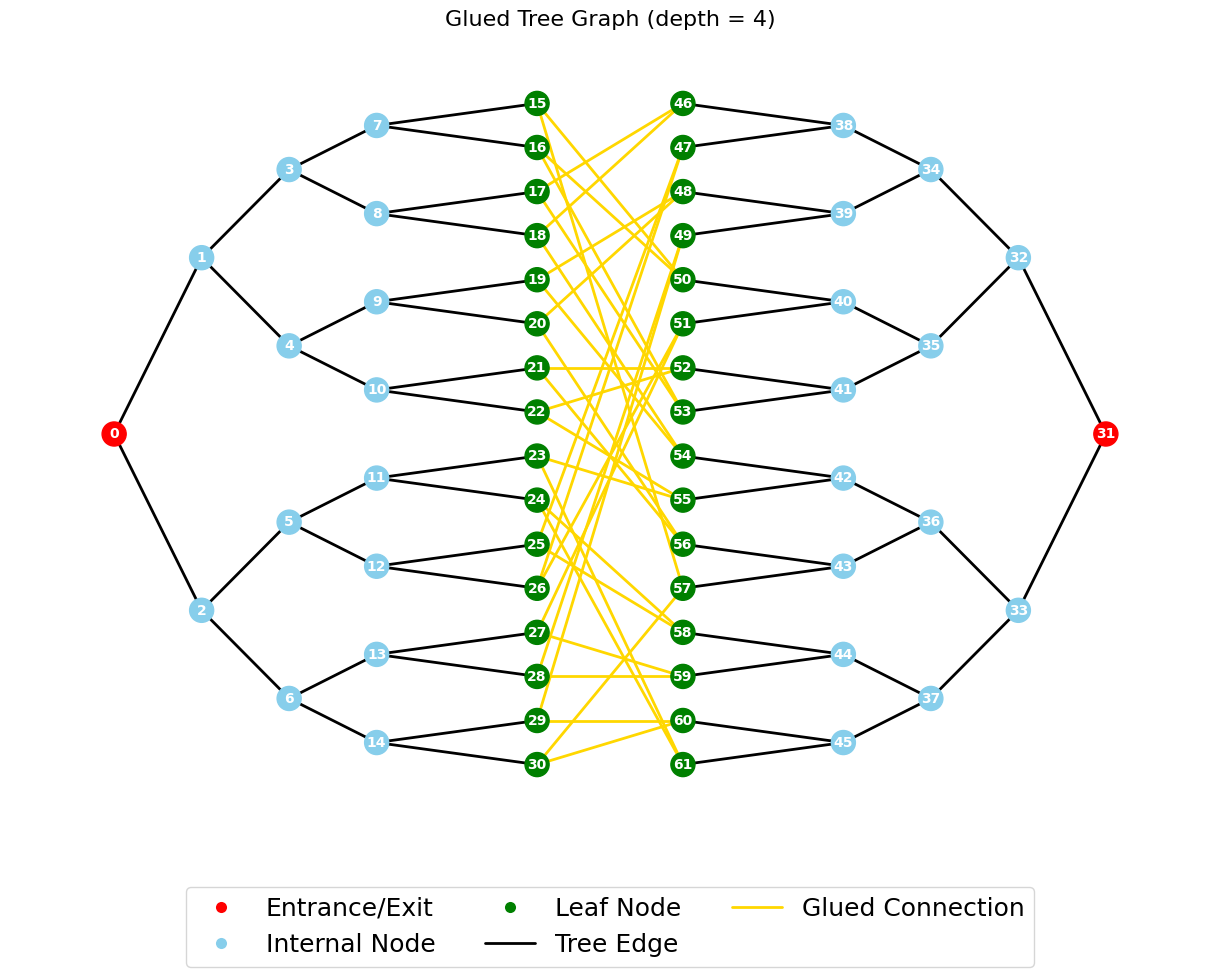

In [30]:
# Generate a Hamiltonian for a glued tree with depth 4 
depth = 4
H = generate_glued_tree_hamiltonian(depth=depth)

# Convert the Hamiltonian to a graph
G = hamiltonian_to_graph(H)

# Identify important components of the graph
components = identify_graph_components(H, depth)
print("\nGraph Components:")
print(f"  Entrance: {components['entrance']}")
print(f"  Exit: {components['exit']}")
print(f"  Tree 0 Leaves: {components['tree0_leaves']}")
print(f"  Tree 1 Leaves: {components['tree1_leaves']}")

# Visualize the graph
visualize_glued_tree_graph(G, depth)

In [31]:
n = 500
dims = (77, 13)
H = column_A(n)

p_100, e_100 = evolve(H, 100, dims)
p_250, e_250 = evolve(H, 250, dims)
p_400, e_400 = evolve(H, 400, dims)
p_600, e_600 = evolve(H, 600, dims)


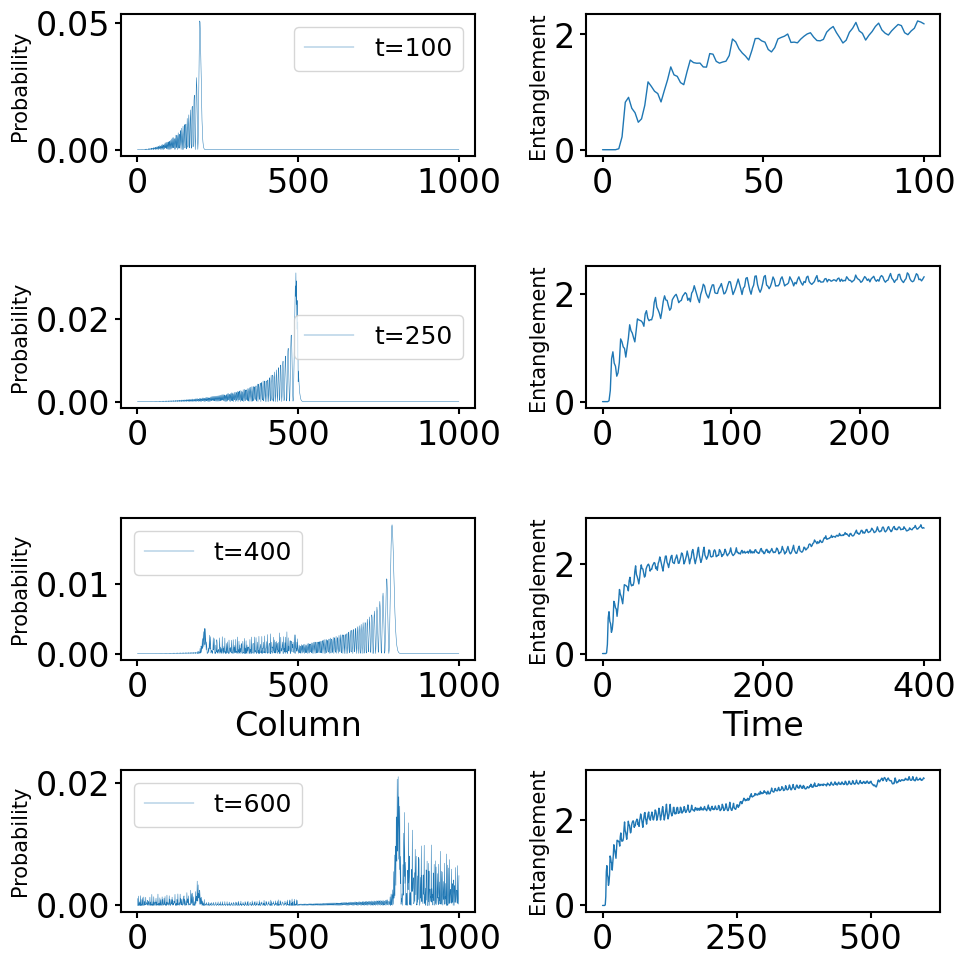

In [36]:
x = np.arange(0, 2*n+1)
t = np.linspace(0, 100, 100)
t1 = np.linspace(0, 250, 250)
t2 = np.linspace(0, 400, 400)
t3 = np.linspace(0, 600, 600)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10), sharex=False)
axes[0, 0].plot(x, p_100, label='t=100', linewidth=0.35)
axes[1, 0].plot(x, p_250, label='t=250', linewidth=0.35)
axes[2, 0].plot(x, p_400, label='t=400', linewidth=0.35)
axes[3, 0].plot(x, p_600, label='t=600', linewidth=0.35)

axes[0, 1].plot(t, e_100, label='t=100', linewidth=1)
axes[1, 1].plot(t1, e_250, label='t=250', linewidth=1)
axes[2, 1].plot(t2, e_400, label='t=400', linewidth=1)
axes[3, 1].plot(t3, e_600, label='t=600', linewidth=1)

axes[2, 0].set_xlabel("Column")
axes[2, 1].set_xlabel("Time")
for i in range(4):
    axes[i, 0].set_ylabel("Probability", fontsize=15)
    axes[i, 0].legend()
    axes[i, 1].set_ylabel("Entanglement", fontsize=15)

### 1D transverse-field Ising (TFI) Hamiltonian with n=8 qubits

In [37]:
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy, schmidt_decomposition

from spin import Nearest_Neighbour_1d
from trotter import expH
from plot_config import *

import numpy as np

In [38]:
n = 8  # number of spins
tfi = Nearest_Neighbour_1d(n, Jx=1, hz=2, pbc=True)
print('The TFI Hamiltonian: ', tfi.ham)

# Initial state: |10...01>
init_state = Statevector.from_label('10'* (n//2)+'1'*(n%2))
# init_state = Statevector.from_label('0'* n)
#init_state_2 = Statevector.from_label('1'* i)
#init_state = (1/np.sqrt(2))*(init_state_1.data + init_state_2.data)

# time steps 
t_list = np.linspace(0, n, 100)
entropy_list, purity_list = [], []

sub_dim = n // 2  # dimension of the subsystem

# Calculate the entanglement measures 
for t in t_list:
    U_exact = expH(tfi.ham, t)
    finl_state = U_exact @ init_state.data
    #finl_state = U_exact @ init_state
    rdm = partial_trace(DensityMatrix(Statevector(finl_state)), list(range(0, sub_dim)))
    # purity_list.append(rdm.purity())
    entropy_list.append(entropy(rdm))
    

The TFI Hamiltonian:  SparsePauliOp(['IIIIIIXX', 'IIIIIXXI', 'IIIIXXII', 'IIIXXIII', 'IIXXIIII', 'IXXIIIII', 'XXIIIIII', 'XIIIIIIX', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 2.+0.j,
 2.+0.j, 2.+0.j, 2.+0.j, 2.+0.j, 2.+0.j, 2.+0.j, 2.+0.j])


Graph representation from TFI Hamiltonian

Here, we parse Pauli strings to find 2-site interactions, which is represented by an edge between two nodes. 

In [39]:
H = tfi.ham 
n = H.num_qubits
A = np.zeros((n, n), dtype=int)

for P, c in zip(H.paulis, H.coeffs):
    label = P.to_label()[::-1] 
    interact = [i for i, ch in enumerate(label) if ch != "I"]
    if len(interact) == 2:
        i, j = interact
        A[i, j] = 1
        A[j, i] = 1
        
n = A.shape[0]
G = nx.Graph()
for i in range(n):
    for j in range(i+1, n):
        if A[i, j] != 0:
            G.add_edge(i, j)

Text(0.5, 1.0, 'Graph Representation')

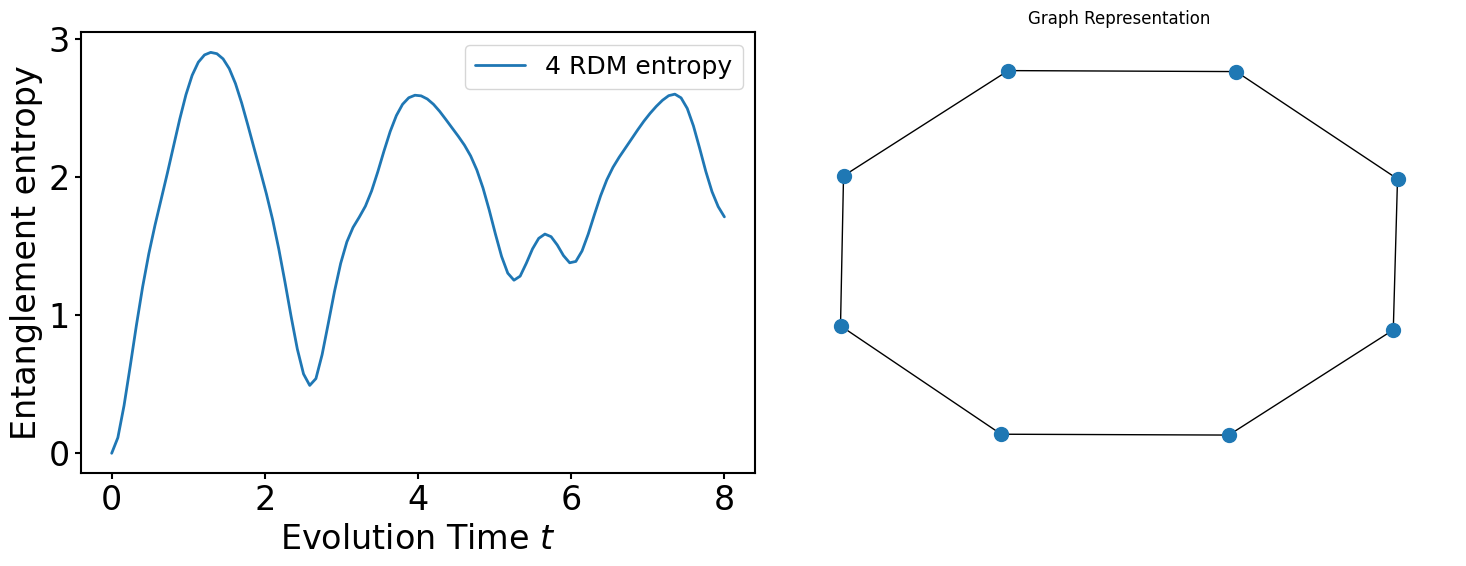

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

axes[0].plot(t_list, entropy_list, label=f'{sub_dim} RDM entropy')
axes[0].set_xlabel(rf'Evolution Time $t$')
axes[0].set_ylabel('Entanglement entropy')
axes[0].legend()

nx.draw(G, node_size=100 , ax=axes[1])
axes[1].set_title("Graph Representation", fontsize=12)